[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


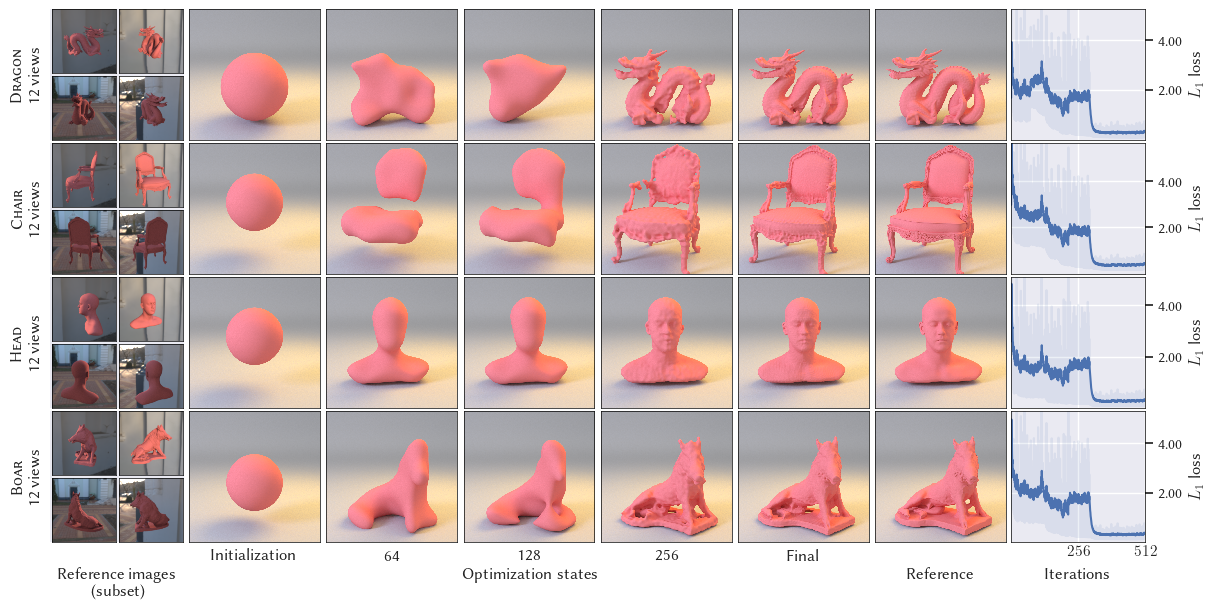

In [1]:
%reload_ext autoreload
%autoreload 2

import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('../'))
from common import *
import configs
import opt_configs

from opt_results_noTex import results

from constants import OUTPUT_DIR
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

import json

sns.set()
sns.set_style('darkgrid', {'axes.edgecolor':'black'})
matplotlib.rcParams['axes.linewidth']= 0.5

fig_name = 'opt_results'
fig_dir = join(FIGURE_DIR, fig_name)
used_configs = [configs.Warp()]
names = ['Ours']

show_iters = [0, 64, 128, 256, 'final']
ref_views = [0, 4, 8, 10]

fontsize = 12
base_size = 2
n_rows = len(results)
n_cols = len(show_iters) + 3
total_width = base_size * n_cols
aspect = 0.98 * n_rows / n_cols

total_width = TEXT_WIDTH
fig = plt.figure(1, figsize=(total_width, aspect * total_width), constrained_layout=False)
iter_rename_dict = {show_iters[-1]: 'Final', 0: 'Initialization'}
gs = fig.add_gridspec(n_rows, n_cols, wspace=0.025, hspace=0.025)

inset_size = 0.2
y_offset = -0.25
ranges = [5e-7, 2e-6, 5e-5]
for row, result in enumerate(results):
    scene, opt_name, pretty_name = result['scene'], result['opt_config'], result['pretty_name']
    opt_config = opt_configs.get_opt_config(opt_name)
    n_views = len(opt_config.sensors)
    output_dir = join(OUTPUT_DIR, scene, opt_config.name, used_configs[0].name)

    # ax = plt.Subplot(fig, gs[row, 0])
    ax = fig.add_subplot(gs[row, 0])
    ax.set_ylabel('\\textsc{' + pretty_name + '}' + '\n' + f'{n_views} views', labelpad=5, fontsize=fontsize)
    if row == n_rows - 1:
        txt = ax.set_title('Reference images \n (subset)', fontsize=fontsize, y=y_offset, va='top')
    disable_ticks(ax)
    disable_border(ax)

    gs_insets = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[row, 0], wspace=0.00, hspace=0.05)

    for idx, ref_view in enumerate(ref_views):
        r = idx // 2
        c = idx % 2
        ax = fig.add_subplot(gs_insets[r, c])
        img = read_img(join(output_dir, f'ref-{ref_view:02d}.exr'))
        ax.imshow(img, interpolation='none')
        disable_ticks(ax)
    col = 1
    r = None
    for cfg in used_configs:
        for show_iter in show_iters:
            ax = fig.add_subplot(gs[row, col])
            suffix = f'{show_iter:04d}' if isinstance(show_iter, int) else show_iter
            fn = join(FIGURE_DIR, fig_name, scene, f'{cfg.name}_{suffix}.exr')
            img = read_img(fn)
            img = img[90:-90, 90:-90, :]
            ax.imshow(img, interpolation='none', extent=[0, 1, 0, 1])
            disable_ticks(ax)
            if row == n_rows - 1 and col > 0:
                label = iter_rename_dict[show_iter] if show_iter in iter_rename_dict else f'{show_iter}'
                txt = ax.set_xlabel(label, fontsize=fontsize, y=-0.5)
                ax.xaxis.set_label_coords(0.5, -0.05)
            if row == n_rows - 1 and col == len(show_iters) // 2 + 1:
                txt = ax.set_title('Optimization states', fontsize=fontsize, y=y_offset, va='top')
            col += 1

        ax = fig.add_subplot(gs[row, col])
        fn = join(FIGURE_DIR, fig_name, scene, f'reference.exr')
        img = read_img(fn)
        img = img[90:-90, 90:-90, :]

        ax.imshow(img, interpolation='none', extent=[0, 1, 0, 1])
        disable_ticks(ax)
        if row == n_rows - 1:
            txt = ax.set_title('Reference', fontsize=fontsize, y=y_offset, va='top')
        col += 1

        # Plot the convergence of the loss values
        output_dir = join(OUTPUT_DIR, scene, opt_config.name, cfg.name)
        with open(join(output_dir, f'metadata.json'), 'r') as f:
            stats = json.load(f)
        ax = fig.add_subplot(gs[row, col])
        loss_scale = 100
        loss_values = loss_scale * np.array(stats['loss_values'])
        ax.plot(loss_values, color=sns.color_palette()[0], alpha=0.1)
        ax.plot(smooth_loss(loss_values, 0.85), color=sns.color_palette()[0])

        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(f'$L_1$ loss')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_ylim(0.01, np.quantile(loss_values, 0.99))
        ax.set_xlim(0, 512)
        ax.axes.get_xaxis().set_ticks([256, 512])
        ax.tick_params(axis='x', pad=-4)
        if row == n_rows - 1:
            txt = ax.set_title('Iterations', fontsize=fontsize, y=y_offset, va='top')
        else:
            ax.axes.get_xaxis().set_ticklabels([])

plt.margins(0, 0)
# save_fig(fig_name)